**Data Pre-Processing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Create Dataframe
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")
# Print shape of dataset
print(df.shape)

(5110, 12)


In [2]:
# First 5 rows of the dataset
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


**DATA CLEANING**

In [3]:
##these are the features with nan value
features_with_na=[features for features in df.columns if df[features].isnull().sum()>=1]
for feature in features_with_na:
    print(feature,np.round(df[feature].isnull().mean()*100,5), '% missing values')

bmi 3.93346 % missing values


**Other Data Cleaning steps**

In [4]:
# Checking for duplicates
df.duplicated().sum()

0

In [5]:
df.drop(['id', 'gender', 'Residence_type'], inplace=True, axis=1)

**FEATURE ENGINEERING**

**Numeric Features**

In [6]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(numeric_features))
numeric_features

Num of Numerical Features : 6


['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

**Categorical Features**

In [7]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(categorical_features))
categorical_features

Num of Categorical Features : 3


['ever_married', 'work_type', 'smoking_status']

**Discrete Features**

In [8]:
discrete_features=[feature for feature in numeric_features if (len(df[feature].unique())<=25)]
print('Num of Discrete Features :',len(discrete_features))
discrete_features

Num of Discrete Features : 3


['hypertension', 'heart_disease', 'stroke']

**Continuous Features**

In [9]:
continuous_features=[feature for feature in numeric_features if len(df[feature].unique()) > 25]
print('Num of Continuous Features :',len(continuous_features))
continuous_features

Num of Continuous Features : 3


['age', 'avg_glucose_level', 'bmi']

**Imputing Null Values to Check VIF(Multi-Collinearity**

In [10]:
# Create copy of dataframe to check variance inflation factor
df1 = df.copy()
for i in continuous_features:
    df1[i].fillna(df1[i].median(), inplace=True)

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [12]:
compute_vif(continuous_features, df1)

,Variable,VIF
0,age,1.162810
1,avg_glucose_level,1.070325
2,bmi,1.128268


**Checking Outliers and Capping it**

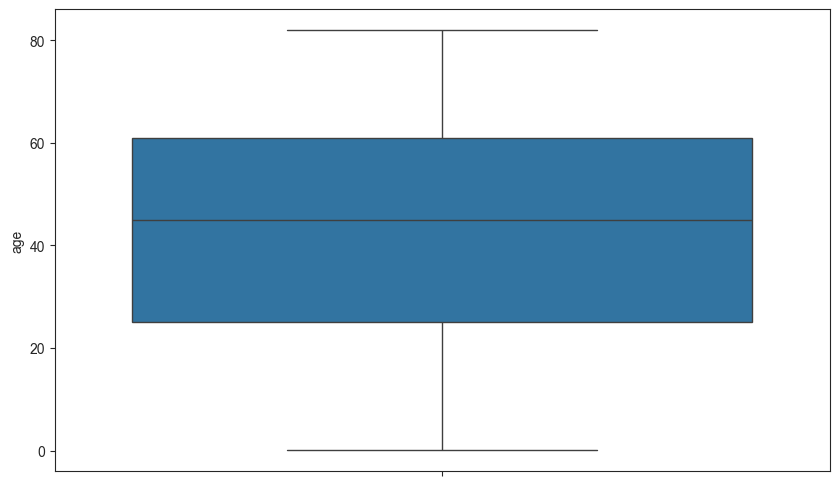

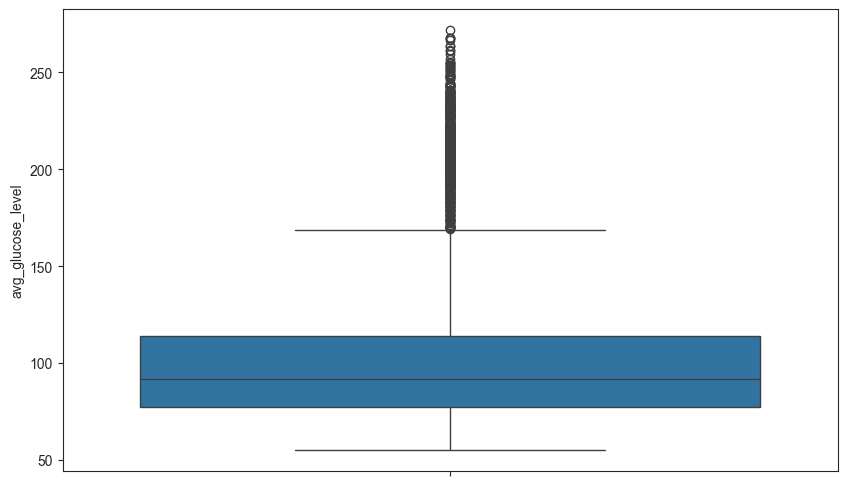

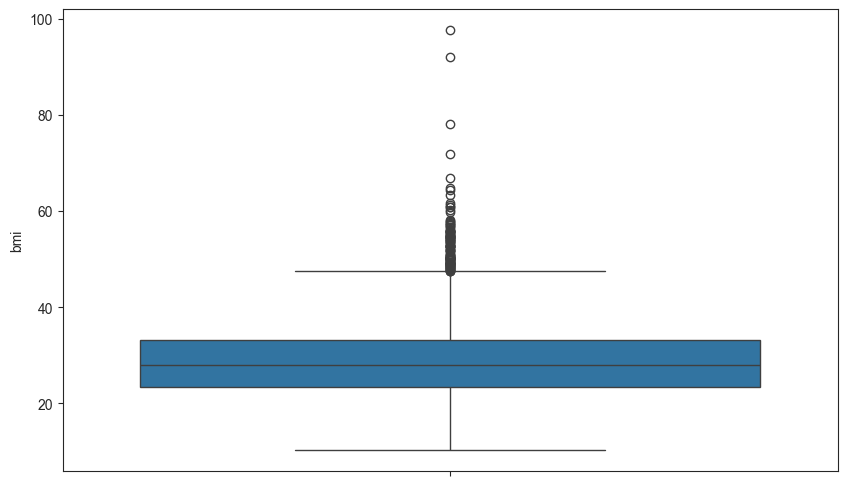

In [13]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Standard deviation method For Outlier Handling?**

In [14]:
def outlier_removal(column, df):
    upper_limit = df[column].mean() + 3*df[column].std()
    lower_limit = df[column].mean() - 3*df[column].std()
    df = df[(df[column] < upper_limit) & (df[column] > lower_limit)]
    return df

In [15]:
df.shape

(5110, 9)

In [16]:
outlier_feature = ['bmi']

In [17]:
for i in range(len(outlier_feature)):
    df = outlier_removal(outlier_feature[i], df)

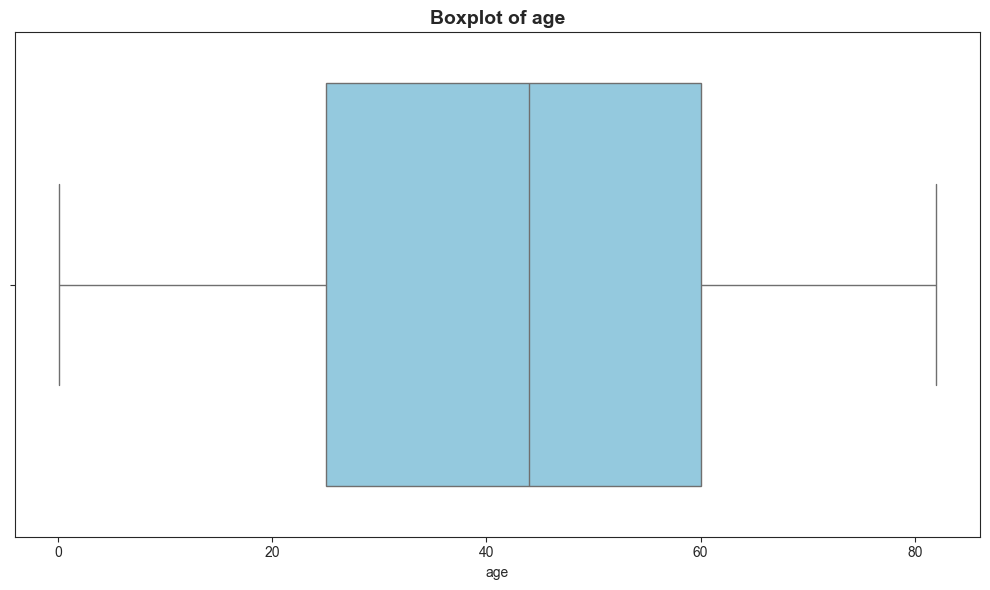

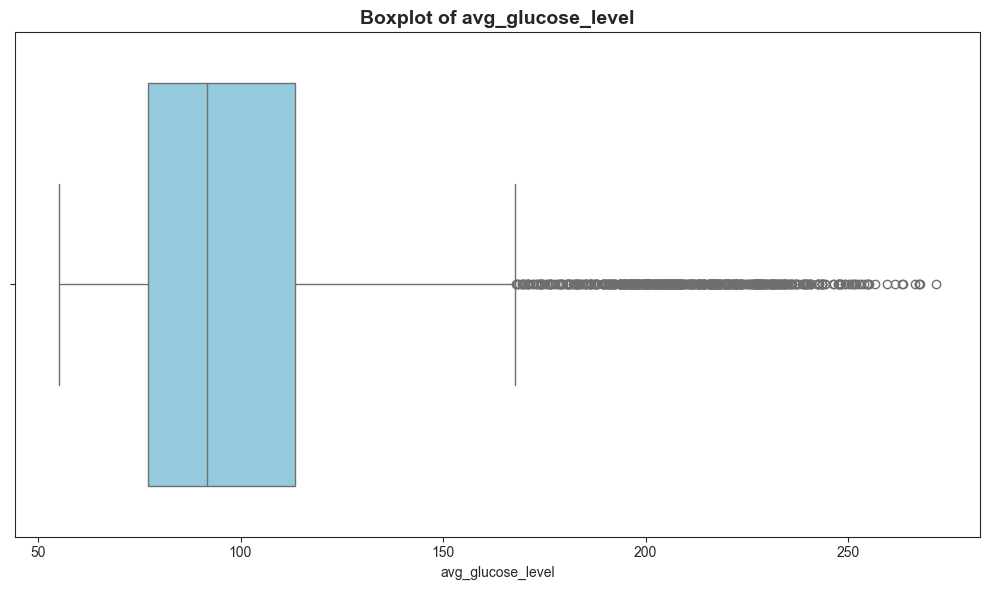

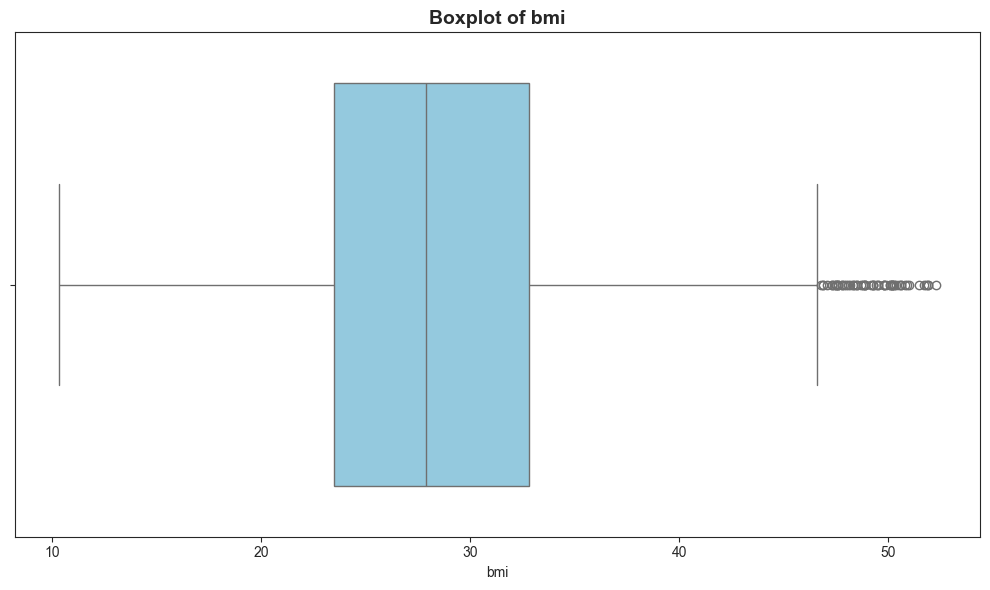

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check if df and features are good
if df is not None and isinstance(df, pd.DataFrame):
    for feature in continuous_features:
        if feature in df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=df[feature], color='skyblue')
            plt.title(f'Boxplot of {feature}', fontsize=14, fontweight='bold')
            plt.xlabel(feature)
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ Column '{feature}' not found in DataFrame.")
else:
    print("❌ df is None or not a valid DataFrame.")


In [19]:
df.shape

(4851, 9)

**Feature Transformation**

In [20]:
df[continuous_features].skew(axis=0)

age                 -0.115593
avg_glucose_level    1.626970
bmi                  0.466922
dtype: float64

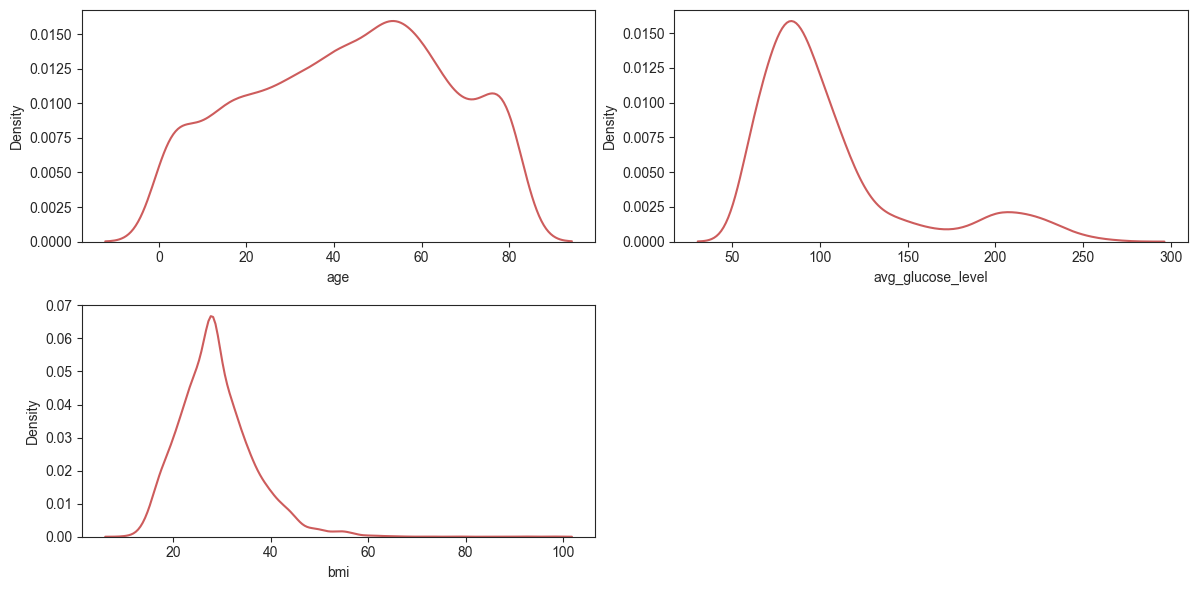

In [21]:
# distribution of data before scaling
plt.figure(figsize=(12, 6))
for i, col in enumerate(continuous_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(x=df1[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

**Split X And Y**

In [22]:
from sklearn.model_selection import train_test_split
X = df.drop(['stroke'], axis=1)
y = df['stroke']

In [23]:
for feature in categorical_features:
    print(feature,':', X[feature].nunique())

ever_married : 2
work_type : 5
smoking_status : 4


**Feature Encoding and Scaling**

**One Hot Encoding for Columns which had lesser unique values and not ordinal**

In [24]:
for i in continuous_features:
    print(f'{i}: mean = {df[i].mean():.2f}, median = {df[i].median():.2f}')

age: mean = 42.83, median = 44.00
avg_glucose_level: mean = 105.10, median = 91.68
bmi: mean = 28.54, median = 27.90


In [25]:
# Create Column Transformer with 3 types of transformers
categorical_features = X.select_dtypes(include="object").columns
num_feature = numeric_features.copy()
num_feature.remove('stroke')
transform_features=['avg_glucose_level']


from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder()),
    ('scaler', StandardScaler(with_mean=False))
]
)

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("numeric_Pipeline",numeric_pipeline,num_feature),
        ("Categorical_Pipeline",categorical_pipeline, categorical_features),
        ("Power_Transformation", transform_pipe, transform_features)
]
)

In [26]:
X= preprocessor.fit_transform(X)

**Handling Imbalanced Dataset**

In [27]:
from imblearn.combine import SMOTETomek, SMOTEENN

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTEENN(random_state=42,sampling_strategy='minority' )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

**Model Selection**

**Train Test Split**

**Import Required packages for model training**

In [28]:
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [29]:
def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [30]:
# Initialize models which are required for models
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [31]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    auc= []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        accuracy_list.append(model_test_accuracy)
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
        
    return report

**Evaluate all base Models**

In [32]:
base_report =evaluate_models(X=X_res, y=y_res, models=models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9797
- F1 score: 0.9807
- Precision: 0.9691
- Recall: 0.9927
- Roc Auc Score: 0.9792


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9354
- F1 score: 0.9388
- Precision: 0.9254
- Recall: 0.9525
- Roc Auc Score: 0.9347


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9247
- F1 score: 0.9301
- Precision: 0.9107
- Recall: 0.9504
- Roc Auc Score: 0.9233
----------------------------------
Model performance for Test set
- Accuracy: 0.9088
- F1 score: 0.9156
- Precision: 0.8825
- Recall: 0.9513
- Roc Auc Score: 0.9070


Logistic Regression
Model performance for Training 

In [33]:
base_report

,Model Name,Accuracy
0,Random Forest,0.979734
5,XGBClassifier,0.973401
4,K-Neighbors Classifier,0.972134
6,CatBoosting Classifier,0.965801
1,Decision Tree,0.935402
2,Gradient Boosting,0.908803
3,Logistic Regression,0.858771
7,AdaBoost Classifier,0.844839


**Here we can use Random Forest , XGBoost Classifier, CatBoost Classifier, KNN classifier for Hyper Parameter Tuning**

In [34]:
#Initialize few parameter for Hyperparamter tuning
xgboost_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [5, 8, 12, 20, 30],
    "n_estimators": [100, 200, 300],
    "colsample_bylevel": [0.5, 0.8, 1, 0.3, 0.4]
}

cat_params = {
    "learning_rate": [0.1, 0.01],
    "max_depth": [10, 15, 30, 20]
}

rf_params = {
    "max_depth": [10, 12, None, 15],
    "max_features": ['sqrt', 'log2', None],
    "min_samples_split": [100, 150, 200, 300],
    "n_estimators": [10, 50, 100, 200]
}

knn_params = {
    "algorithm": ['auto', 'ball_tree', 'kd_tree','brute'],
    "weights": ['uniform', 'distance'],
    "n_neighbors": [3, 4, 5, 7, 9],
}

In [35]:
# Models list for Hyperparameter tuning
randomcv_models = [
    ('XGBoost', XGBClassifier(), xgboost_params),
    ('CatBoost', CatBoostClassifier(verbose=False), cat_params),
    ("RF", RandomForestClassifier(), rf_params),
    ("KNN", KNeighborsClassifier(), knn_params)
]

In [36]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_res, y_res)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 40 candidates, totalling 120 fits
---------------- Best Params for XGBoost -------------------
{'n_estimators': 200, 'max_depth': 30, 'learning_rate': 0.1, 'colsample_bylevel': 0.4}
---------------- Best Params for CatBoost -------------------
{'max_depth': 15, 'learning_rate': 0.1}
---------------- Best Params for RF -------------------
{'n_estimators': 50, 'min_samples_split': 100, 'max_features': 'log2', 'max_depth': None}
---------------- Best Params for KNN -------------------
{'weights': 'distance', 'n_neighbors': 3, 'algorithm': 'auto'}


**Retraining the Model with best Parameters**

In [37]:
from sklearn.metrics import roc_auc_score,roc_curve
best_models = {
    "Random Forest Classifier": RandomForestClassifier(**model_param['RF']),
    "KNeighborsClassifier": KNeighborsClassifier(**model_param['KNN']),
    "XGBClassifier": XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
    "CatBoosting Classifier": CatBoostClassifier(**model_param['CatBoost'],verbose=False),
}
tuned_report =evaluate_models(X=X_res, y=y_res, models=best_models)

Random Forest Classifier
Model performance for Training set
- Accuracy: 0.9303
- F1 score: 0.9353
- Precision: 0.9149
- Recall: 0.9567
- Roc Auc Score: 0.9288
----------------------------------
Model performance for Test set
- Accuracy: 0.9202
- F1 score: 0.9254
- Precision: 0.8999
- Recall: 0.9525
- Roc Auc Score: 0.9189


KNeighborsClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9848
- F1 score: 0.9856
- Precision: 0.9716
- Recall: 1.0000
- Roc Auc Score: 0.9842


XGBClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9778
- F1 score: 0.9790
- Precision: 0.9634
- Recall: 0.9951
- Roc Auc Score: 0.9771


CatBoosting Classifier
Model performa

In [38]:
tuned_report

,Model Name,Accuracy
3,CatBoosting Classifier,0.985434
1,KNeighborsClassifier,0.984801
2,XGBClassifier,0.977834
0,Random Forest Classifier,0.920203


**Plot Roc Auc Curve**

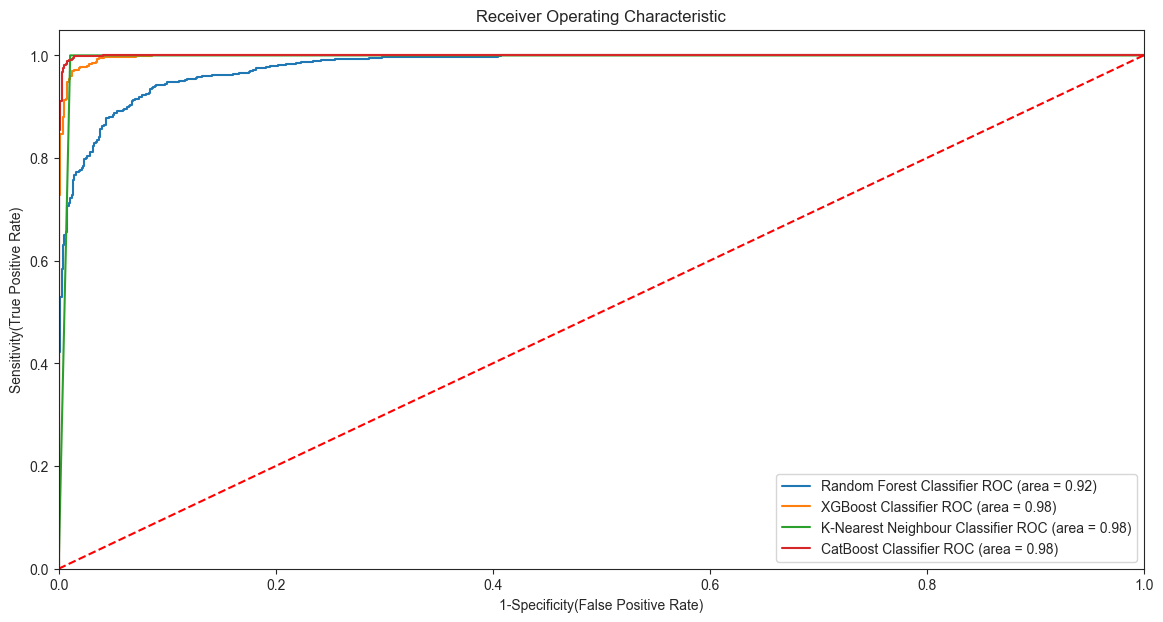

In [39]:
from sklearn.metrics import roc_auc_score,roc_curve
# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Random Forest Classifier',
    'model': RandomForestClassifier(**model_param['RF']),
    'auc': 0.9152
},
{
    'label': 'XGBoost Classifier',
    'model': XGBClassifier(**model_param['XGBoost'],n_jobs=-1),
    'auc': 0.9785
},
{
    'label': "K-Nearest Neighbour Classifier",
    'model': KNeighborsClassifier(**model_param['KNN']),
    'auc': 0.9842 
},
{
    'label': 'CatBoost Classifier',
    'model': CatBoostClassifier(**model_param['CatBoost'],verbose=False),
    'auc': 0.9849
},
]

X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
# create loop through all model
plt.figure(figsize=(14,7))
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# plt.savefig(r"./images/auc.png")
plt.show()   # Display

**Final report**

In [40]:
best_model = CatBoostClassifier(**model_param['CatBoost'], verbose=False)
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = accuracy_score(y_test,y_pred)
cr = classification_report(y_test,y_pred)

print("FINAL MODEL 'CATBOOST'")
print ("Accuracy Score value: {:.4f}".format(score))
print (cr)

FINAL MODEL 'CATBOOST'
Accuracy Score value: 0.9854
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       758
           1       0.97      1.00      0.99       821

    accuracy                           0.99      1579
   macro avg       0.99      0.98      0.99      1579
weighted avg       0.99      0.99      0.99      1579



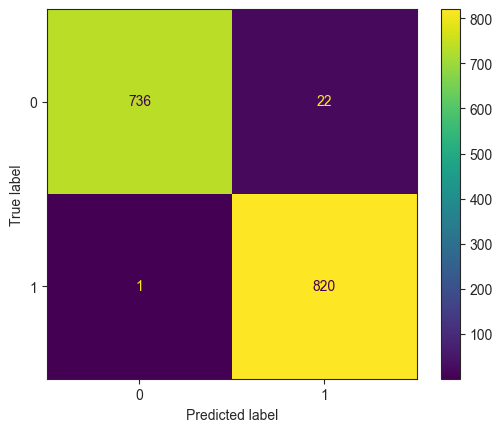

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

***Best Model is CatBoost Classifier with 98.54 % Accuracy***